# Sarcastic Headline Detection w/ BERT

### Problem

In this noteook, I will be predicting if a news headline is sarcasm. This News Headlines dataset for Sarcasm Detection is collected from two news website.   
**_The Onion_**, which aims at producing sarcastic versions of current events.   
**_The Huffington Post_**, which is a real (non-sarcastic) news outlet.  

### Context

- `is_sarcastic`: 1 if the headline is sarcastic, otherwise 0
- `headline`: The headline of the news article
- `article_link`: The link to the original news article

### Models

This problem is a binary classification problem where I will be using two models. A baseline of **Naive Bayes** and a more advanced **Deep Neural Network (DNN)** design using **BERT** as a base layer with multiple convolutional and dense layers to predict the sarcastic headlines.

For implementing **BERT**, I will be fine-tuning BERT by freezing it's trainable layers and only training the additional layers underneath.

*Note: The results from the DNN were trained on two tesla V100 32GB GPU's*

### Measure of success

For this problem, I will define the measure of success by using *accuracy* because the dataset contains almost equal numbers of each predictors.

**Number of binary labels**  
Not Sarcastic: 29,970  
Sarcastic: 25,358

Dataset Link: https://www.kaggle.com/rmisra/news-headlines-dataset-for-sarcasm-detection

**Imports**

In [1]:
# 1. Importing some of the builtin and popular libraries for data science tasks.

import numpy as np # NumPy is a useful linear algebra library for Python.
import pandas as pd # Pandas is a data manipulation library.
import matplotlib.pyplot as plt # Matplotlib is a plotting library.
import string # String module contains various string constants.
import os # OS module in Python provides functions for interacting with the operating system.
from datetime import datetime # The datetime module supplies classes for manipulating dates and times.

In [2]:
# 2. Importing some libraries for NLP

import tensorflow as tf # TensorFlow is an end-to-end open source platform for machine learning.
import tensorflow_hub as hub # TensorFlow Hub is a library for the publication, discovery, and consumption of reusable parts of machine learning models.
from keras.utils import np_utils # Keras is a deep learning API written in Python.
from tensorflow.keras.callbacks import ModelCheckpoint, ReduceLROnPlateau, EarlyStopping # Callbacks for training and saving the model.

# SciKit Learn Libraries: The scikit-learn library is one of the most popular library for general machine learning in Python.
from sklearn.model_selection import train_test_split # Split arrays or matrices into random train and test subsets.
from sklearn.metrics import classification_report, confusion_matrix # Build a text report showing the main classification metrics and plot a confusion matrix.
from sklearn.feature_extraction.text import TfidfVectorizer # Convert a collection of raw documents to a matrix of TF-IDF features.
from sklearn.naive_bayes import MultinomialNB # The multinomial Naive Bayes classifier is suitable for classification with discrete features (e.g., word counts for text classification).
from sklearn.pipeline import make_pipeline # Construct a Pipeline from the given estimators.
from sklearn.model_selection import train_test_split # Split arrays or matrices into random train and test subsets.
plt.style.use('ggplot') # Use ggplot style for plotting with matplotlib.

Enable GPU growth

In [3]:
# 3. The following code is used to check the GPU availability.
gpus = tf.config.experimental.list_physical_devices('GPU') # List of Physical GPUs.
if gpus: # If there is a GPU.
  try:
    # Currently, memory growth needs to be the same across GPUs
    for gpu in gpus: # For each GPU.
      tf.config.experimental.set_memory_growth(gpu, True) # Set memory growth to True.
    logical_gpus = tf.config.experimental.list_logical_devices('GPU') # List of Logical GPUs.
    print(len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPUs") # Print the number of Physical and Logical GPUs.
  except RuntimeError as e: # If there is a runtime error then the code will print the error.
    # Memory growth must be set before GPUs have been initialized.
    print(e) # Print the error.

1 Physical GPUs, 1 Logical GPUs


In [4]:
# 4. The following code is used to download the dataset from GitHub.
# The dataset is available at https://www.kaggle.com/rmisra/news-headlines-dataset-for-sarcasm-detection

url1 = "https://raw.githubusercontent.com/manavhirani/Sarcastic-Headline-Detection-with-BERT/main/data/Sarcasm_Headlines_Dataset.json" # Replace with your custom URL if needed.
# Storing the url of Sarcasm_Headlines_Dataset.json in a variable.
url2 = "https://raw.githubusercontent.com/manavhirani/Sarcastic-Headline-Detection-with-BERT/main/data/Sarcasm_Headlines_Dataset_v2.json" # Replace with your custom URL if needed.
# Storing the url of Sarcasm_Headlines_Dataset_v2.json in a variable.

# If you would like to download the dataset from Kaggle to your google drive, then you can use the following code.
# from google.colab import drive
# drive.mount('/content/drive')
# import os
# data_dir = '/content/drive/MyDrive/data/'
# os.path.exists(data_dir)

In [5]:
# 5. The following code is used to read the dataset from the url.

raw_data_1 = pd.read_json(url1, lines=True) # Read the json file from url1.
raw_data_2 = pd.read_json(url2, lines=True) # Read the json file from url2.

# If you used google drive earlier then use the following code.
# raw_data_1 = pd.read_json(data_dir + 'Sarcasm_Headlines_Dataset.json', lines=True)
# raw_data_2 = pd.read_json(data_dir + 'Sarcasm_Headlines_Dataset_v2.json', lines=True)

In [6]:
# 6. Viewing the first dataset.

raw_data_1.head() # Print the first few rows of raw_data_1.

,article_link,headline,is_sarcastic
0,https://www.huffingtonpost.com/entry/versace-b...,former versace store clerk sues over secret 'b...,0
1,https://www.huffingtonpost.com/entry/roseanne-...,the 'roseanne' revival catches up to our thorn...,0
2,https://local.theonion.com/mom-starting-to-fea...,mom starting to fear son's web series closest ...,1
3,https://politics.theonion.com/boehner-just-wan...,"boehner just wants wife to listen, not come up...",1
4,https://www.huffingtonpost.com/entry/jk-rowlin...,j.k. rowling wishes snape happy birthday in th...,0


In [7]:
# 7. Viewing the second dataset.

raw_data_2.head() # Print the first few rows of raw_data_2.

,is_sarcastic,headline,article_link
0,1,thirtysomething scientists unveil doomsday clo...,https://www.theonion.com/thirtysomething-scien...
1,0,dem rep. totally nails why congress is falling...,https://www.huffingtonpost.com/entry/donna-edw...
2,0,eat your veggies: 9 deliciously different recipes,https://www.huffingtonpost.com/entry/eat-your-...
3,1,inclement weather prevents liar from getting t...,https://local.theonion.com/inclement-weather-p...
4,1,mother comes pretty close to using word 'strea...,https://www.theonion.com/mother-comes-pretty-c...


In [8]:
# 8. The following code is used to check the shape of the dataset including the number of rows and columns.

print('Dataset 1 has {} columns and {} rows'.format(raw_data_1.shape[0], raw_data_1.shape[1])) # Print the shape of raw_data_1.
print('Dataset 2 has {} columns and {} rows'.format(raw_data_2.shape[0], raw_data_2.shape[1])) # Print the shape of raw_data_2.

Dataset 1 has 26709 columns and 3 rows
Dataset 2 has 28619 columns and 3 rows


Join both together

In [9]:
# 9. The following code is used to concatenate the two datasets.

complete_data_raw = pd.concat([raw_data_1, raw_data_2]).reset_index(drop=True).copy() # Concatenate the two datasets.

In [10]:
# 10. Viewing the combined dataset.

complete_data_raw.head() # Print the first few rows of complete_data_raw.

,article_link,headline,is_sarcastic
0,https://www.huffingtonpost.com/entry/versace-b...,former versace store clerk sues over secret 'b...,0
1,https://www.huffingtonpost.com/entry/roseanne-...,the 'roseanne' revival catches up to our thorn...,0
2,https://local.theonion.com/mom-starting-to-fea...,mom starting to fear son's web series closest ...,1
3,https://politics.theonion.com/boehner-just-wan...,"boehner just wants wife to listen, not come up...",1
4,https://www.huffingtonpost.com/entry/jk-rowlin...,j.k. rowling wishes snape happy birthday in th...,0


In [11]:
# 11. The following code is used to check the shape of the combined dataset.
complete_data_raw.shape # Print the shape of complete_data_raw.

(55328, 3)

There are 55,328 total rows in the dataset

In [12]:
# 12. The following code is used to find the number of sarcastic and non-sarcastic headlines.
num_sarcastic = complete_data_raw['is_sarcastic'].value_counts()[1] # Number of sarcastic headlines.
num_not_sarcastic = complete_data_raw['is_sarcastic'].value_counts()[0] # Number of non-sarcastic headlines.

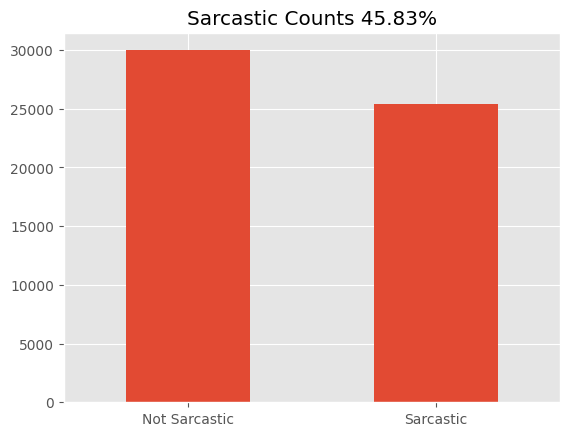

In [13]:
# 13. The following code is used to plot the number of sarcastic and non-sarcastic headlines.

complete_data_raw['is_sarcastic'].value_counts().plot(kind='bar') # Plot the number of sarcastic and non-sarcastic headlines.
plt.xticks([0,1], ['Not Sarcastic', 'Sarcastic'], rotation=0) # Set the xticks.
plt.title('Sarcastic Counts {:.2f}%'.format((num_sarcastic / (num_sarcastic + num_not_sarcastic)*100))); # Set the title.

Overall, this dataset is fairly balanced

**Pre-processing**

For pre-processing the data, I will only be removing the punctuations and capitalizations in order to preserve as much of the original headlines as possible

In [14]:
# 14. Copy the original data
complete_data_preprocessed = complete_data_raw.copy() # Copy the original data to complete_data_preprocessed.

In [15]:
# 15. The following code will lowercase the headline column.
complete_data_preprocessed['headline'] = complete_data_preprocessed['headline'].str.lower() # Lowercase the headline column.

In [16]:
# 16. The following code will remove punctuations from the headline column.

def remove_punctuations(text): # Define a function to remove punctuations.
    for punctuation in string.punctuation: # For each punctuation, string.punctuation contains all the common punctuations in English.
        text = text.replace(punctuation, '') # Replace the punctuation with an empty string.
    return text # Return the text.

complete_data_preprocessed['headline'] = complete_data_preprocessed['headline'].apply(remove_punctuations) # Apply the remove_punctuations function to the headline column as a lambda function.

In [17]:
# 17. View the preprocessed data.
complete_data_preprocessed.head() # Print the first few rows of complete_data_preprocessed.

,article_link,headline,is_sarcastic
0,https://www.huffingtonpost.com/entry/versace-b...,former versace store clerk sues over secret bl...,0
1,https://www.huffingtonpost.com/entry/roseanne-...,the roseanne revival catches up to our thorny ...,0
2,https://local.theonion.com/mom-starting-to-fea...,mom starting to fear sons web series closest t...,1
3,https://politics.theonion.com/boehner-just-wan...,boehner just wants wife to listen not come up ...,1
4,https://www.huffingtonpost.com/entry/jk-rowlin...,jk rowling wishes snape happy birthday in the ...,0


**Checking for duplicates**

In [18]:
# 18. The following code is used to check for duplicates in the dataset.

complete_data_preprocessed[complete_data_preprocessed.duplicated()].shape # Print the shape of the duplicated rows.

(26711, 3)

There are 26,711 duplicate entries in the dataset. YIKES!  
I will remove those.

In [19]:
# 19. The following code is used to drop the duplicates in the dataset.

complete_data_preprocessed.drop_duplicates(inplace=True) # Drop the duplicates in the dataset.
complete_data_preprocessed.shape # Print the shape of the dataset.

(28617, 3)

In [20]:
# 20. The following code counts the number of sarcastic and non-sarcastic headlines.
num_sarcastic = complete_data_preprocessed['is_sarcastic'].value_counts()[1] # Number of sarcastic headlines.
num_not_sarcastic = complete_data_preprocessed['is_sarcastic'].value_counts()[0] # Number of non-sarcastic headlines.

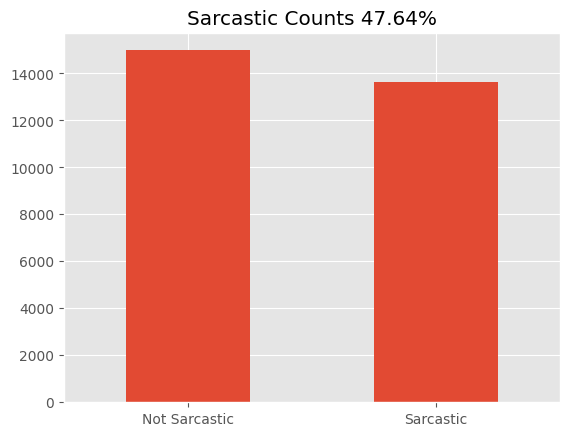

In [21]:
# 21. The following code is used to plot the number of sarcastic and non-sarcastic headlines.

complete_data_preprocessed['is_sarcastic'].value_counts().plot(kind='bar') # Plot the number of sarcastic and non-sarcastic headlines.
plt.xticks([0,1], ['Not Sarcastic', 'Sarcastic'], rotation=0) # Set the xticks.
plt.title('Sarcastic Counts {:.2f}%'.format((num_sarcastic / (num_sarcastic + num_not_sarcastic)*100))); # Set the title.

Now that the data does not contain duplicates and is pre-processed, I will first begin with a baseline Naive Bayes model.

**Creating a dataset with stopwords removed**

In [22]:
# 22. Create a set of stopwords.
standford_stopwords = {"'ll", "'m", "'s", 'a', 'about', 'above', 'after', 'again', 'against', 'ah', 'all', 'am', 'an', 'and', 'any', 'are', "aren't", 'arent', 'as', 'at', 'be', 'because', 'been', 'before', 'being', 'below', 'between', 'both', 'but', 'by', 'can', "can't", 'cannot', 'cant', 'could', "couldn't", 'couldnt', 'did', "didn't", 'didnt', 'do', 'does', "doesn't", 'doesnt', 'doing', "don't", 'dont', 'down', 'during', 'each', 'er', 'er', 'few', 'for', 'from', 'further', 'had', "hadn't", 'hadnt', 'has', "hasn't", 'hasnt', 'have', "haven't", 'havent', 'having', 'he', "he'd", "he'll", "he's", 'her', 'here', "here's", 'heres', 'hers', 'herself', 'hes', 'him', 'himself', 'his', 'how', "how's", 'hows', 'i', "i'd", "i'll", "i'm", "i've", 'if', 'im', 'in', 'into', 'is', "isn't", 'isnt', 'it', "it's", 'its', 'itself', "let's", 'lets', 'like', 'me', 'more', 'most', "mustn't", 'mustnt', 'my', 'myself', 'no', 'nor', 'not', 'of', 'off', 'oh', 'okay', 'on', 'once', 'only', 'or', 'other', 'ought', 'our', 'ours ', 'ourselves', 'out', 'over', 'own', 'return', 'right', 'same', "shan't", 'shant', 'she', "she'd", "she'll", "she's", 'shes', 'should', "shouldn't", 'shouldnt', 'so', 'some', 'such', 'than', 'that', "that's", 'thats', 'the', 'their', 'theirs', 'them', 'themselves', 'then', 'there', "there's", 'theres', 'these', 'they', "they'd", "they'll", "they're", "they've", 'theyll', 'theyre', 'theyve', 'this', 'those', 'through', 'to', 'too', 'uh', 'um', 'under', 'until', 'up', 'very', 'was', "wasn't", 'wasnt', 'we', "we'd", "we'll", "we're", "we've", 'well', 'were', "weren't", 'werent', 'what', "what's", 'whats', 'when', "when's", 'whens', 'where', "where's", 'wheres', 'which', 'while', 'who', "who's", 'whom', 'whos', 'why', "why's", 'whys', 'with', "won't", 'wont', 'would', "wouldn't", 'wouldnt', 'yeah', 'you', 'you know', "you'd", "you'll", "you're", "you've", 'youd', 'youll', 'your', 'youre', 'yours', 'yourself', 'yourselves', 'youve'}

In [23]:
# 23. The following code is used to tokenize the headlines after removing the stopwords.

def remove_stopwords(tokens: list(), stop_words: set(), replace: str = None) -> list(): # Define a function to remove stopwords.
    filtered = [] # Initialize an empty list to store the filtered tokens.
    ### Removing stop words
    for word in tokens: # For each word in the tokens.
        if word not in stop_words: # If the word is not in the stop words.
            filtered.append(word) # Append the word to the filtered list.
        else: # If the word is in the stop words.
            if replace is not None: # If the replace parameter is not None.
                filtered.append(replace) # Append the replace parameter to the filtered list.
    return filtered # Return the filtered list.

In [24]:
# 24. This function is used to clean the response.
def clean_response(row): # Define a function to clean the response.
    response_list = row.split() # Split the response into a list of words.
    response_list_cleaned = remove_stopwords(response_list, standford_stopwords) # Remove the stopwords from the response.
    return ' '.join(response_list_cleaned) # Return the cleaned response.

In [25]:
# 25. Printing a sample response before cleaning.
complete_data_preprocessed['headline'][2] # Print the sample response before cleaning.

'mom starting to fear sons web series closest thing she will have to grandchild'

In [26]:
# 26. Testing the clean_response function by passing the sample response.
clean_response(complete_data_preprocessed['headline'][2])

'mom starting fear sons web series closest thing will grandchild'

Apply to whole dataset

In [27]:
# 27. Applying the clean_response function to the entire dataset.
complete_data_preprocessed['headline_no_stopwords'] = complete_data_preprocessed['headline'].apply(clean_response) # Cleaning the whole dataset.
complete_data_preprocessed # Print the dataset.

,article_link,headline,is_sarcastic,headline_no_stopwords
0,https://www.huffingtonpost.com/entry/versace-b...,former versace store clerk sues over secret bl...,0,former versace store clerk sues secret black c...
1,https://www.huffingtonpost.com/entry/roseanne-...,the roseanne revival catches up to our thorny ...,0,roseanne revival catches thorny political mood...
2,https://local.theonion.com/mom-starting-to-fea...,mom starting to fear sons web series closest t...,1,mom starting fear sons web series closest thin...
3,https://politics.theonion.com/boehner-just-wan...,boehner just wants wife to listen not come up ...,1,boehner just wants wife listen come alternativ...
4,https://www.huffingtonpost.com/entry/jk-rowlin...,jk rowling wishes snape happy birthday in the ...,0,jk rowling wishes snape happy birthday magical...
...,...,...,...,...
55206,https://www.theonion.com/tyson-holds-contest-t...,tyson holds contest to let fans submit new ide...,1,tyson holds contest let fans submit new ideas ...
55218,https://politics.theonion.com/increasingly-coc...,increasingly cocky bernie sanders announces he...,1,increasingly cocky bernie sanders announces ta...
55229,https://www.theonion.com/cash-strapped-zuckerb...,cashstrapped zuckerberg forced to sell 11 mill...,1,cashstrapped zuckerberg forced sell 11 million...
55253,https://local.theonion.com/grocery-store-bar-a...,grocery store bar actually has great little ha...,1,grocery store bar actually great little happy ...


**Data Exploration**

*Counting how many unique words there are in the dataset*

In [28]:
# 28. Counting unique words in the dataset.

all_entries = '' # Initialize an empty string to store all the words in the dataset.
for i in range(complete_data_preprocessed.shape[0]): # For each row in the dataset.
    try:
        all_entries += str(complete_data_preprocessed['headline'][i]) + ' ' # Append the headline to the string.
    except:
        continue # Continue if there is an error.

all_entries = all_entries.split() # Split the string into a list of words.
total_words = len(np.unique(np.array(all_entries))) # Count the number of unique words in the list.
print('There are {} total words in the dataset'.format(total_words)) # Print the number of unique words in the dataset.

There are 28523 total words in the dataset


### Naive Bayes (Baseline)

In [29]:
# 29. Importing the required libraries for the baseline Naive Bayes model.
from sklearn.feature_extraction.text import TfidfVectorizer # TF-IDF Vectorizer to vectorize the text.
from sklearn.naive_bayes import MultinomialNB # Multinomial Naive Bayes model.
from sklearn.pipeline import make_pipeline # Pipeline to combine the vectorizer and the model.
from sklearn.model_selection import train_test_split # Train test split to split the data into training and testing sets.

**Split dataset into training and testing data**

In [30]:
# 30. Splitting the data into training and testing sets.

X = complete_data_preprocessed['headline'] # The input features are the headlines.
y = complete_data_preprocessed['is_sarcastic'] # The target variable is the is_sarcastic column.

X_train, X_test, y_train, y_test = train_test_split(X, y,  # Splitting the data into training and testing sets.
                                                    test_size=0.2, # 20% for testing, 80% for training 
                                                    random_state=43) # Initializing for reproducibility

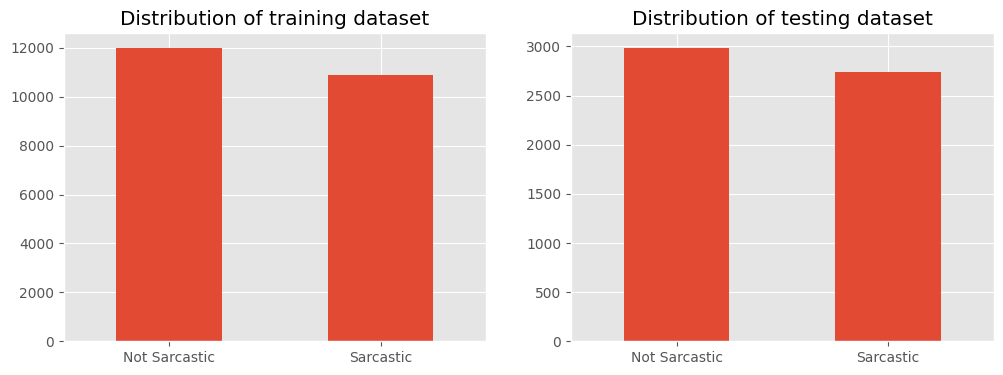

In [31]:
# 31. Plotting the distribution of the training and testing sets.
fig, (ax1, ax2) = plt.subplots(1,2, figsize=(12,4)) # Initialize a figure with two subplots.

y_train.value_counts().plot.bar(ax=ax1) # Plot the distribution of the training set.
plt.sca(ax1) # Set the current axes.
plt.title('Distribution of training dataset') # Set the title of the plot.
plt.xticks([0,1],['Not Sarcastic','Sarcastic'], rotation=0) # Set the xticks.

y_test.value_counts().plot.bar(ax=ax2) # Plot the distribution of the testing set.
plt.sca(ax2)   # Set the current axes.
plt.title('Distribution of testing dataset') # Set the title of the plot.
plt.xticks([0,1],['Not Sarcastic','Sarcastic'], rotation=0); # Set the xticks.

In [32]:
# 32. Training the baseline Naive Bayes model.
model = make_pipeline(TfidfVectorizer(), MultinomialNB()) # Initialize the pipeline.
model.fit(X_train, y_train) # Fit the model on the training data.

Pipeline(steps=[('tfidfvectorizer', TfidfVectorizer()),
                ('multinomialnb', MultinomialNB())])

In [33]:
# 33. Making predictions on the testing set.
y_predict = model.predict(X_test) # Predict on the testing set.

In [34]:
# 34. Printing the baseline accuracy.
print('Baseline Accuracy: {:.2f}%'.format((y_test == y_predict).mean() * 100)) # Print the baseline accuracy.

Baseline Accuracy: 82.91%


We were able to accurately predict if a headline is sarcastic around 83% of the time. Next, I will be using a much more complex DNN model to improve this accuracy.

### BERT Tensorflow Implementation

**Pre-processing**

1.   Split data into train, validation, and test datasets
2.   Encode labels
3.   Tokenize text

*Removing Duplicates in the dataset*

In [35]:
# 35. Removing duplicate rows from the dataset.

num_rows_b4 = complete_data_raw.shape[0] # Store the number of rows before removing duplicates.
complete_data_raw.drop_duplicates(inplace=True) # Drop the duplicates.
num_rows_after = complete_data_raw.shape[0] # Store the number of rows after removing duplicates.
print('{} duplicate rows dropped'.format(num_rows_b4 - num_rows_after)) # Print the number of duplicate rows dropped.
print('New number of rows in data set:', complete_data_raw.shape[0]) # Print the new number of rows in the dataset.

26711 duplicate rows dropped
New number of rows in data set: 28617


*Shuffling the dataset*

In [36]:
# 36. Shuffling the dataset.
df = complete_data_raw[['headline','is_sarcastic']].sample(frac=1, random_state=42).copy() # Rename the dataset.
df.head() # Print the first five rows of the dataset.

,headline,is_sarcastic
44904,christian bale loses 40 years for upcoming mov...,1
1660,jon stewart and 9/11 responders walk the halls...,0
96,inhofe's grand climate conspiracy theory: it's...,0
6237,amber rose fearful over breast reduction surge...,0
6650,23-hour suicide watch a failure,1


*Finding the optimal `input_length` to feed into the DNN*

In [37]:
# 37. The following code finds different statistical insughts about the headlines.

def give_length(text): # Define a function to give the number of words in a headline.
    return len(text.split())

df['headline_length'] = df['headline'].apply(give_length) # Apply the function to the dataset.
print('Max Headline Length {}'.format(df['headline_length'].max())) # Print the maximum headline length.
print('Mean Headline Length {:.2f}'.format(df['headline_length'].mean())) # Print the mean headline length.
print('Median Headline Length {}'.format(df['headline_length'].median())) # Print the median headline length.
print('Third Quantile Headline Length {}'.format(np.percentile(df['headline_length'], 75))) # Print the third quantile headline length.
print('90% Headline Length {}'.format(np.percentile(df['headline_length'], 90))) # Print the 90th percentile headline length.
print('99.99% Headline Length {}'.format(np.percentile(df['headline_length'], 99.99))) # Print the 99.99th percentile headline length.

Max Headline Length 151
Mean Headline Length 10.05
Median Headline Length 10.0
Third Quantile Headline Length 12.0
90% Headline Length 14.0
99.99% Headline Length 31.96879999997327


Text(0.5, 0, 'Headline Length')

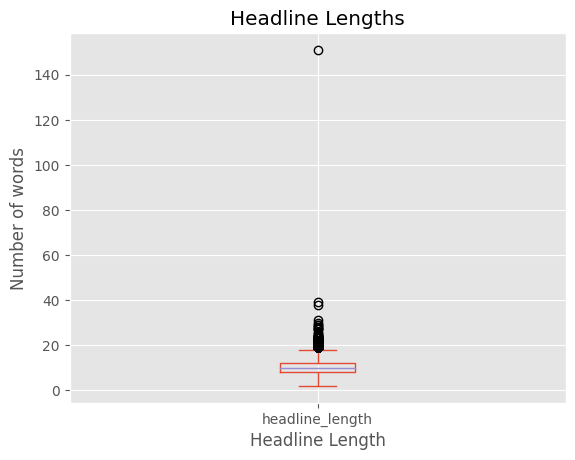

In [38]:
# 38. Plotting the distribution of the headline lengths.
df['headline_length'].astype(float).plot.box() # Plot the boxplot.
plt.title('Headline Lengths') # Set the title of the plot.
plt.ylabel('Number of words') # Set the y-axis label.
plt.xlabel('Headline Length') # Set the x-axis label.

**Creating our test, training, validation datasets**

- Training (~70%)
- Validation (~20%)
- Testing (~10%)

In [39]:
# 39. Calculating the number of samples in each of the splits.

num_samples = df.shape[0] # Total number of samples.
training_samples = int(np.percentile(np.arange(num_samples), 70)) # 70% of the data for training.
validation_samples = int(np.percentile(np.arange(num_samples), 20)) # 20% of the data for validation.

In [40]:
# 40. Print the number of samples in each of the splits.

print('{} number of samples'.format(num_samples)) # Print the total number of samples.
print('{} training samples'.format(training_samples)) # Print the number of training samples.
print('{} validation samples'.format(validation_samples)) # Print the number of validation samples.
print('{} testing samples'.format(num_samples - training_samples - validation_samples)) # Print the number of testing samples.

28617 number of samples
20031 training samples
5723 validation samples
2863 testing samples


In [41]:
# 41. Splitting the data into training, validation and testing sets.
data = df['headline'] # The input features are the headlines.
labels = df['is_sarcastic'] # The target variable is the is_sarcastic column.

x_train = data[:training_samples] # x_train is the training data.
y_train = labels[:training_samples] # y_train is the training labels.
x_val = data[training_samples: training_samples + validation_samples] # x_val is the validation data.
y_val = labels[training_samples: training_samples + validation_samples] # y_val is the validation labels.
x_test = data[training_samples + validation_samples:] # x_test is the testing data.
y_test = labels[training_samples + validation_samples:] # y_test is the testing labels.

In [42]:
# 42. Print the shape of the training, validation and testing sets.
### Sanity Check
# Assert statements are used to check if the following conditions are true. If they are not, an error is raised.
assert(x_train.shape[0] == training_samples) # Are the number of training samples correct?
assert(y_train.shape[0] == training_samples) # Are the number of training labels correct?
assert(x_val.shape[0] == validation_samples) # Are the number of validation samples correct?
assert(y_val.shape[0] == validation_samples) # Are the number of validation labels correct?
assert(x_test.shape[0] == num_samples - training_samples - validation_samples) # Are the number of testing samples correct?
assert(y_test.shape[0] == num_samples - training_samples - validation_samples) # Are the number of testing labels correct?

**Pre-Processing**

*Turning the tokenization process into functions*

In [43]:
# 43. Downloading the BERT model, the one used here is the multilingual BERT model.
# The model is downloaded from TensorFlow Hub.
# This might take a few minutes.

bert_layer = hub.KerasLayer("https://tfhub.dev/tensorflow/bert_multi_cased_L-12_H-768_A-12/2", trainable=False) ### Download BERT
# The above line downloads the BERT model from TensorFlow Hub and stores it in the bert_layer variable.
# bert_multi_cased_L-12_H-768_A-12/2 is the name of the model.
# Let's break down what this name means.
# BERT = Bidirectional Encoder Representations from Transformers
# multi = multilingual. This model can be used for multiple languages.
# cased = case-sensitive. This model is case-sensitive.
# L-12 = 12 layers. The model has 12 layers.
# H-768 = 768 hidden units. The model has 768 hidden units.
# A-12 = 12 attention heads. The model has 12 attention heads.

In [44]:
# 44. JAX is a library for high-performance machine learning research.
# Not having the latest version of JAX installed might create dependency issues and raise errors.
!pip install jax --upgrade # Use % instead of ! if you are using a Jupyter Notebook.
# %pip install jax --upgrade # Install the latest version of JAX.

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [45]:
# 45. Installing the official TensorFlow models library.
!pip install tf-models-official # Use % instead of ! if you are using a Jupyter Notebook.
# %pip install tf-models-official # Make sure you have this library installed.
# Also if you are on an Apple Silicon Mac, you might have to install the nightly version of TensorFlow.
# You can do this by running the following command.
# $ pip install tf-models-no-deps

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.6/2.6 MB 50.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 50.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 118.9/118.9 kB 19.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 175.1/175.1 kB 23.9 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 240.6/240.6 kB 28.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.0/6.0 MB 72.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 43.6/43.6 kB 6.2 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 591.0/591.0 kB 50.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 17.1/17.1 MB 56.5 MB/s eta 0:00:00
  C

In [46]:
# 46. Import tokenization from the official.nlp.tools library.
import official.nlp.tools.tokenization as tokenization # Import tokenization from the official.nlp.tools library.
vocab_file = bert_layer.resolved_object.vocab_file.asset_path.numpy() # Get the path to the vocab file.
do_lower_case = bert_layer.resolved_object.do_lower_case.numpy() # Get the value of the do_lower_case variable.
tokenizer = tokenization.FullTokenizer(vocab_file, do_lower_case) # Build the tokenizer using the vocab file and do_lower_case variable.
# 1. vocab_file: reads the vocab file associated to the downloaded model.
# 2. do_lower_case: reads binary variable which if True means tokenizer will reformat all text to lower 
#    case rendering model to be **NOT** case sensitive. Should be False by default. You can check in a cell below.
# 3. tokenizer: builds tokenizer using variables 1 and 2. It is a FullTokenizer object which is a class that has 
#    3 methods: tokenize, convert_tokens_to_ids and convert_ids_to_tokens.

In [47]:
# 47. This is a helper function to encode the headlines.
def encode_names(n, tokenizer): 
    tokens = list(tokenizer.tokenize(n)) ### Tokenizes the string
    tokens.append('[SEP]') ### Add a [SEP] token to the end of each headline
    return tokenizer.convert_tokens_to_ids(tokens) ### Returns an array of Token ID's

In [48]:
# 48. This function uses encode_names to encode the headlines, and then uses tf.ragged.constant to create a constant tensor from a ragged array.
def bert_encode(string_list, tokenizer, max_seq_length): # Define a function to encode the headlines using the tokenizer.
    num_examples = len(string_list) # Get the number of headlines.

    ### Encodes all the headlines as token ID's
    string_tokens = tf.ragged.constant([encode_names(n, tokenizer) for n in np.array(string_list)]) # Create a ragged constant tensor from a ragged array.

    cls = [tokenizer.convert_tokens_to_ids(['[CLS]'])]*string_tokens.shape[0] ### Creates an array of [CLS] token ID's
    input_word_ids = tf.concat([cls, string_tokens], axis=-1) ### Appends it to the front of all the headlines

    input_mask = tf.ones_like(input_word_ids).to_tensor(shape=(None, max_seq_length)) ### Creating an input mask of 1 and 0's

    ### Create and append a 0 to the beginning of the input mask for the [CLS] token 
    type_cls = tf.zeros_like(cls) # Create a tensor of 0's of the same shape as cls.
    type_tokens = tf.ones_like(string_tokens) # Create a tensor of 1's of the same shape as string_tokens.
    input_type_ids = tf.concat([type_cls, type_tokens], axis=-1).to_tensor(shape=(None, max_seq_length)) # Concatenate the two tensors.
    
    ### Puts everything into a dict
    inputs = {
      'input_word_ids': input_word_ids.to_tensor(shape=(None, max_seq_length)),
      'input_mask': input_mask,
      'input_type_ids': input_type_ids} # Create a dictionary of the inputs.

    return inputs # Return the inputs.

*Processing our training, testing, and validation sets*

In [49]:
# 49. Encode the headlines using the bert_encode function for the training, validation and testing headlines.
max_seq_length = 151 # Maximum headline length

X_train = bert_encode(x_train, tokenizer, max_seq_length) # Encode the training headlines.
X_test = bert_encode(x_test, tokenizer, max_seq_length) # Encode the testing headlines.
X_val = bert_encode(x_val, tokenizer, max_seq_length) # Encode the validation headlines.

### BERT architecture

In [50]:
# 50. Setting up the model architecture.

# Dropping out 20% of the embeddings on any given round of training
drop_embed = 0.2 # Dropout rate for the embeddings

# CNN Layer Architecture
n_conv_1 = n_conv_2 = n_conv_3 = 256 # Number of filters for the convolutional layers

In [51]:
# 51. Some more model architecture parameters.

# Filter lengths of 4, 5, and 6 words
k_conv_1 = 4 
k_conv_2 = 5
k_conv_3 = 6

# dense layer architecture: 
n_dense = 256 # Number of neurons in the dense layer
dropout = 0.2 # Dropout rate for the dense layer

In [52]:
# 52. Define the input layers.

input_word_ids = tf.keras.layers.Input(shape=(max_seq_length,), dtype=tf.int32,name="input_word_ids") # Input layer for the word ID's
input_mask = tf.keras.layers.Input(shape=(max_seq_length,), dtype=tf.int32,name="input_mask") # Input layer for the input mask
segment_ids = tf.keras.layers.Input(shape=(max_seq_length,), dtype=tf.int32, name="segment_ids") # Input layer for the segment ID's

In [53]:
# 53. Define the BERT layer using the three input layers we just created.
pooled_output, sequence_output = bert_layer([input_word_ids, input_mask, segment_ids])
# pooled_output: represents each input sequence as a whole.
# sequence_output: represents each input token in the context 

In [54]:
# 54. Define the CNN layer architecture.
drop_embed_layer = tf.keras.layers.SpatialDropout1D(drop_embed, name='drop_embed')(sequence_output)
# SpatialDropout1D: This version performs the same function as Dropout, 
# however it drops entire 1D feature maps instead of individual elements.

In [55]:
# 55. Continue defining the CNN layer architecture.

### Three parallel convolutional streams:
conv_1 = tf.keras.layers.Conv1D(filters=n_conv_1, kernel_size=k_conv_1, activation='relu', name='conv_1')(drop_embed_layer)
maxp_1 = tf.keras.layers.GlobalMaxPooling1D(name='maxp_1')(conv_1)
# The first convolutional stream uses a filter length of 4 words.

conv_2 = tf.keras.layers.Conv1D(n_conv_2, k_conv_2, activation='relu', name='conv_2')(drop_embed_layer)
maxp_2 = tf.keras.layers.GlobalMaxPooling1D(name='maxp_2')(conv_2)
# The second convolutional stream uses a filter length of 5 words.

conv_3 = tf.keras.layers.Conv1D(n_conv_3, k_conv_3, activation='relu', name='conv_3')(drop_embed_layer)
maxp_3 = tf.keras.layers.GlobalMaxPooling1D(name='maxp_3')(conv_3)
# The third convolutional stream uses a filter length of 6 words.

In [56]:
# 56. Concatenate the activations from three convolutional streams.
concat = tf.keras.layers.concatenate([maxp_1, maxp_2, maxp_3])


In [57]:
# 57. Define the dense layer architecture.
dense_layer_1 = tf.keras.layers.Dense(256, activation='relu', name='Dense_1')(concat)
dense_layer_dropout_1 = tf.keras.layers.Dropout(rate=0.2, name='Dense_Dropout_1')(dense_layer_1)
# The above is a dense layer with 256 neurons and a dropout rate of 20%.

dense_layer_2 = tf.keras.layers.Dense(64, activation='relu', name='Dense_2')(dense_layer_dropout_1)
dense_layer_dropout_2 = tf.keras.layers.Dropout(rate=0.1, name='Dense_Dropout_2')(dense_layer_2)
# The above is a dense layer with 64 neurons and a dropout rate of 10%.

In [58]:
# 58. Define the output layer.
output = tf.keras.layers.Dense(1, activation='sigmoid', name='output')(dense_layer_dropout_2) # Output layer

In [59]:
# 59. Define the model inputs and outputs.
model = tf.keras.Model( 
    inputs={
        'input_word_ids': input_word_ids, # Input layer for the word ID's
        'input_mask': input_mask, # Input layer for the input mask
        'input_type_ids': segment_ids # Input layer for the segment ID's
        },
        outputs=output) # Create a model using the inputs and outputs.

In [60]:
# 60. View a summary of the model's architecture.
model.summary() # This shows the architecture of the model.

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_word_ids (InputLayer)    [(None, 151)]        0           []                               
                                                                                                  
 input_mask (InputLayer)        [(None, 151)]        0           []                               
                                                                                                  
 segment_ids (InputLayer)       [(None, 151)]        0           []                               
                                                                                                  
 keras_layer (KerasLayer)       [(None, 768),        177853441   ['input_word_ids[0][0]',         
                                 (None, 151, 768)]                'input_mask[0][0]',         

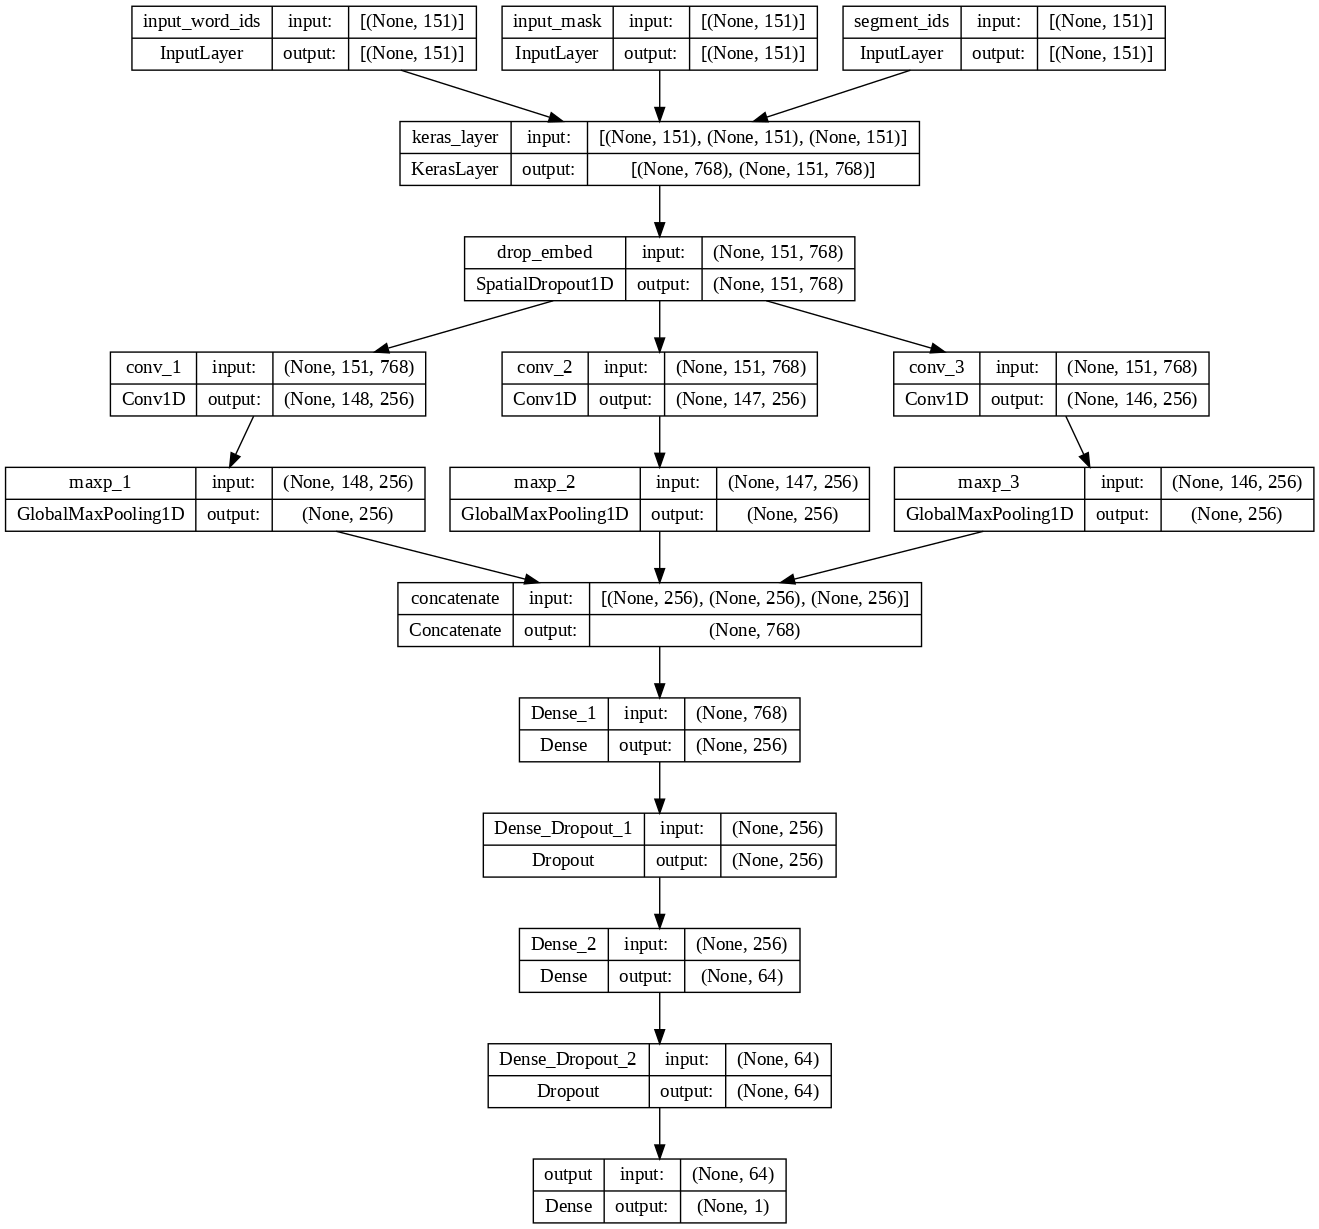

In [61]:
# 61. Plotting the model's architecture.
tf.keras.utils.plot_model(model, show_shapes=True, dpi=100) # Plot the model's architecture.

<img src="Sarcasm img.png">

Create a directory with the date

In [62]:
# 62. Creating a directory to save the model's output with the current date.
now = datetime.now() # current date and time
year = now.strftime("%Y") # Get the current year
month = now.strftime("%m") # Get the current month
day = now.strftime("%d") # Get the current day
date = month+day+year # Concatenate the year, month and day

### Create an output directory
output_dir = './scratch/dlilenth/model_output/bert_multi_cased_L-12_H-768_A-12_v2_fixed_convs_' + date # Create a directory to save the model's output
if not os.path.exists(output_dir): ### If the file directory doesn't already exists,
    os.makedirs(output_dir) ### Make it please

Compile the model

In [63]:
# 63. Compile the model.
model.compile(optimizer='adam', # Optimizer
              loss='binary_crossentropy', # Loss function
              metrics=['accuracy']) # Accuracy performance metric

**Train!!**

I will be implementing early stopping and reducing learning rates as part of the training process

In [64]:
# 64. Model checkpoint callback. This saves the model's weights after each epoch if it's the best yet.
modelcheckpoint = ModelCheckpoint(filepath=output_dir+'/weights.{epoch:02d}.hdf5')

In [65]:
# 65. Early stopping callback. This stops the model's training if it hasn't improved after 3 epochs.
early_stopping = EarlyStopping(patience=3, # Stop after 3 epochs of no improvement
                               monitor='val_loss', # Look at validation_loss
                               min_delta=0, # After 0 change
                               mode='min', # Stop when quantity has stopped decreasing
                               restore_best_weights=False, # Don't Restore the best weights
                               verbose=1)

In [66]:
# 66. Reduce learning rate on plateau callback. This reduces the learning rate if the model's performance hasn't improved after 1 epoch.
reduce_lr = ReduceLROnPlateau(monitor='val_loss', # Look at validation loss
                              min_lr=0.000001, # Lower bound of learning rate
                              patience=1, # Reduce after 1 with little change
                              mode='min', # Stop when quantity has stopped decreasing
                              factor=0.1, # Reduce by a factor of 1/10
                              min_delta=0.01, # Minimumn change needed
                              verbose=1)

In [67]:
# 67. Train the model.
history = model.fit(X_train, # Training data
                    y_train, # Training labels
                    epochs=10, # Number of epochs
                    batch_size=16, # Batch size
                    validation_data=(X_val, y_val), # Validation data
                    callbacks=[modelcheckpoint, early_stopping, reduce_lr], # Callbacks
                    verbose=1) # Print out progress

Epoch 1/10
1252/1252 [==============================] - 358s 263ms/step - loss: 0.4170 - accuracy: 0.8047 - val_loss: 0.3080 - val_accuracy: 0.8684 - lr: 0.0010
Epoch 2/10
1252/1252 [==============================] - ETA: 0s - loss: 0.2774 - accuracy: 0.8827
Epoch 2: ReduceLROnPlateau reducing learning rate to 0.00010000000474974513.
1252/1252 [==============================] - 309s 247ms/step - loss: 0.2774 - accuracy: 0.8827 - val_loss: 0.3020 - val_accuracy: 0.8703 - lr: 0.0010
Epoch 3/10
1252/1252 [==============================] - 325s 259ms/step - loss: 0.1699 - accuracy: 0.9331 - val_loss: 0.2689 - val_accuracy: 0.8896 - lr: 1.0000e-04
Epoch 4/10
1252/1252 [==============================] - ETA: 0s - loss: 0.1388 - accuracy: 0.9465
Epoch 4: ReduceLROnPlateau reducing learning rate to 1.0000000474974514e-05.
1252/1252 [==============================] - 325s 260ms/step - loss: 0.1388 - accuracy: 0.9465 - val_loss: 0.2837 - val_accuracy: 0.8927 - lr: 1.0000e-04
Epoch 5/10
1252/1252

In [68]:
# 68. A function to plot the model's training history.
def plot_history(history): # Function to plot the model's training history
    acc = history.history['accuracy'] # Get the training accuracy
    val_acc = history.history['val_accuracy'] # Get the validation accuracy
    loss = history.history['loss'] # Get the training loss
    val_loss = history.history['val_loss'] # Get the validation loss
    x = range(1, len(acc) + 1) # Create a range of the number of epochs

    plt.figure(figsize=(12, 5)) # Set the figure size
    plt.subplot(1, 2, 1) # Create a subplot
    plt.plot(x, acc, 'b', label='Training acc') # Plot the training accuracy
    plt.plot(x, val_acc, 'r', label='Validation acc') # Plot the validation accuracy
    plt.title('Training and validation accuracy') # Set the title
    plt.legend() # Set the legend
    plt.subplot(1, 2, 2) # Create a subplot
    plt.plot(x, loss, 'b', label='Training loss') # Plot the training loss
    plt.plot(x, val_loss, 'r', label='Validation loss') # Plot the validation loss
    plt.title('Training and validation loss') # Set the title
    plt.legend() # Set the legend
    print("Lowest Validation Loss: epoch {}".format(np.argmin(val_loss)+1)) # Print the epoch with the lowest validation loss
    print("Highest Training Accuracy: epoch {}".format(np.argmax(val_acc)+1)) # Print the epoch with the highest training accuracy

Lowest Validation Loss: epoch 3
Highest Training Accuracy: epoch 5


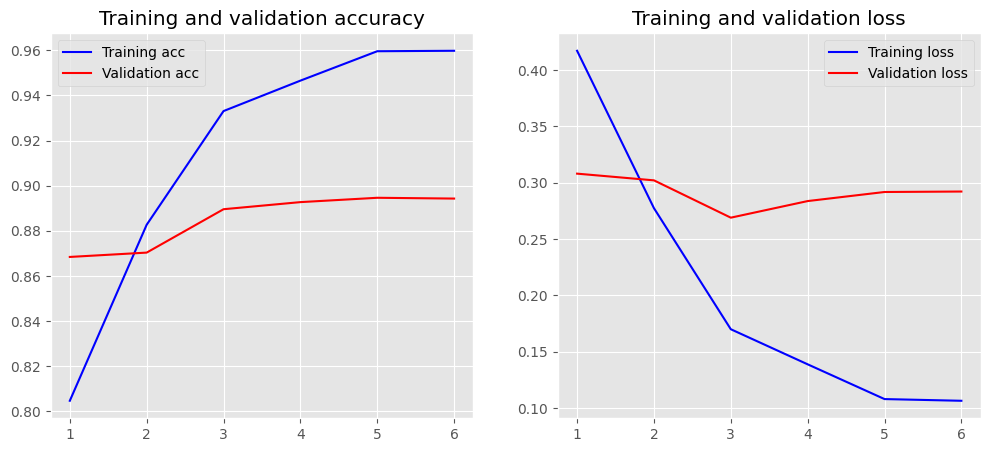

In [69]:
# 69. Plot the model's training history.
plot_history(history) # Calling the function we declared earlier.

**Load in the model with the best validation accuracy**

In [70]:
# 70. Load in the model's weights with the best validation accuracy.
model.load_weights(output_dir+"/weights.05.hdf5") # Load in model weights

*Evaluate on the test set*

In [71]:
# 71. Evaluate the model on the test data.
y_test_hat = model.predict(X_test) # Predict on the test data
y_hat = (y_test_hat > 0.5).astype(int).flatten() # Convert the predictions to binary

90/90 [==============================] - 33s 361ms/step


Text(0.5, 1.0, 'Confidence of predictions')

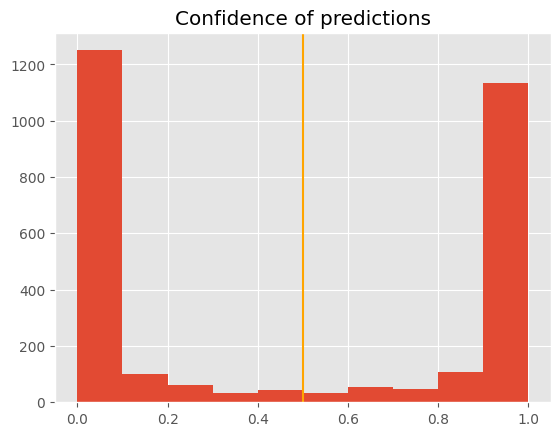

In [72]:
# 72. 
plt.hist(y_test_hat) # Plot the distribution of the predictions
_ = plt.axvline(x=0.5, color='orange') ### Fitting the traditional .5 accuracy threshold is
plt.title('Confidence of predictions') # Set the title, which is the confidence of the predictions

Our model has more *Not Sarcastic* (**0**) predictions than *Sarcastic* (**1**). This is reflective of the dataset containing slightly more *Not Sarcastic* examples. 

In [73]:
# 73. Print the model's performance on the test data.
print(classification_report(y_test, y_hat, target_names=['Not Sarcastic', 'Sarcastic'])) # Print the classification report

               precision    recall  f1-score   support

Not Sarcastic       0.90      0.90      0.90      1499
    Sarcastic       0.89      0.89      0.89      1364

     accuracy                           0.90      2863
    macro avg       0.90      0.90      0.90      2863
 weighted avg       0.90      0.90      0.90      2863



We achieved a 90% accuracy on the results

*Confusion Matrix*

Text(113.9222222222222, 0.5, 'Actual')

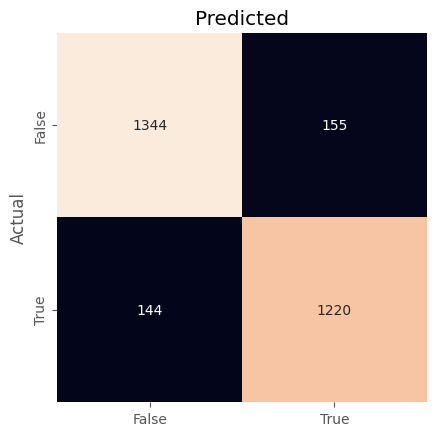

In [74]:
# 74. Plot the confusion matrix.
import seaborn as sns # Import seaborn, a visualization library for Python based on matplotlib.
matrix = confusion_matrix(y_test, y_hat) # Create a confusion matrix
sns.heatmap(matrix, square=True, annot=True, fmt='d', cbar=False,
            xticklabels=['False','True'], yticklabels=['False','True']) # Plot the confusion matrix
plt.title('Predicted') # Set the title
plt.ylabel('Actual') # Set the y-axis label

**Taking a look at which observations we got wrong**

In [75]:
# 75. Print the number of observations we guessed incorrectly.
print('There are {} oberservations we guessed incorrectly'.format(x_test[(y_test != y_hat)].shape[0]))
# This will access all the indices in x_test where y_test != y_hat

There are 299 oberservations we guessed incorrectly


Observations that were predicted **True** *(y_hat = 1)* but actually **False** *(y_test = 0)*

*Printing the first 10 examples*

In [76]:
# 76. The first 10 examples where we incorrectly predicted sarcasm.
[print(example) for example in x_test[(y_test == 0)&(y_hat == 1)][:10]]

astronomers discover most distant galaxy yet
nyc removes statue honoring 19th century surgeon who experimented on female slaves
remarkable new documentary on burma's children
rnc proclaims mike pence the winner more than an hour before the debate
christianity's hijacked brand
pre-holiday jerry brown preps for term 4
facebook built censorship tool to appease china expansion
mom gives excuse for son's absence that even hermione would accept
orangutan's horrific death underscores need for brands to use certified palm oil
toothbrush melts into oblivion in surprisingly hypnotic video


[None, None, None, None, None, None, None, None, None, None]

We can see here that some of the examples the model guessed incorrectly sound like they could actually be a real headline.

*Printing the first 10 examples*

Observations that were predicted **False** *(y_hat = 0)* but actually **True** *(y_test = 1)*

In [77]:
# 77. The first 10 examples where we incorrectly predicted not sarcasm.
[print(example) for example in x_test[(y_test == 1)&(y_hat == 0)][:10]]

swiss threaten ricola embargo
producer wants to call movie crime and punishment anyway
senate subcommittee on energy and water development more like a family
pursued drunk driver crafts brilliant 'don't stop' plan
new ed mcmahon autobiography reveals he slept with 7 women
trump accidentally fires off 'boring mike pence' tweet during vp speech before he can stop himself
tiny dog suffocates in louis vuitton bag
trump confirms all violent options on the table in venezuela
hotshot test pilot removes helmet, reveals female status
orrin hatch: 'as a father of daughters, i don't give a flying fuck what happens to them'


[None, None, None, None, None, None, None, None, None, None]

Some of the examples the model guessed incorrectly here do seem like they could be fake headlines, but are actually real. 

**Create a function to make predictions yourself**

In [78]:
# 78. Making a prediction on a new headline.
sentence = "Trump, at US-Mexican border, slams Biden for ‘open, really dangerous’ border".lower()
# Pulled from fox news
prediction = model.predict(bert_encode([remove_punctuations(sentence)], tokenizer, 151))
# Converting the sentence to lowercase and removing punctuation, then using tokenizer to encode it with a max length of 151.
print("Model predicted: {}".format("Sarcastic" if (prediction[0][0] > 0.5).astype(int).flatten() == 1 else "Not Sarcastic"))

1/1 [==============================] - 0s 193ms/step
Model predicted: Not Sarcastic


In [79]:
# 79. Making a prediction on a new headline.
sentence = "Frenchwoman who killed abusive husband faints in court as prosecutors seek sentence that could see her walk free".lower()
### Pulled from CNN
prediction = model.predict(bert_encode([remove_punctuations(sentence)], tokenizer, 151))
print("Model predicted: {}".format("Sarcastic" if (prediction[0][0] > 0.5).astype(int).flatten() == 1 else "Not Sarcastic"))

1/1 [==============================] - 0s 25ms/step
Model predicted: Not Sarcastic


In [80]:
# 80. Making a prediction on a new headline.
sentence = "Donald Trump Reportedly Wanted Military To 'Beat The F**k' Out Of George Floyd Protesters".lower()
### Pulled from huffington post
prediction = model.predict(bert_encode([remove_punctuations(sentence)], tokenizer, 151))
print("Model predicted: {}".format("Sarcastic" if (prediction[0][0] > 0.5).astype(int).flatten() == 1 else "Not Sarcastic"))

1/1 [==============================] - 0s 26ms/step
Model predicted: Not Sarcastic


In [81]:
# 81. Making a prediction on a new headline.
sentence = "Infrastructure Talks Come To Halt After Giant Sinkhole Swallows Capitol Building".lower()
### Pulled from the Onion.com
prediction = model.predict(bert_encode([remove_punctuations(sentence)], tokenizer, 151))
print("Model predicted: {}".format("Sarcastic" if (prediction[0][0] > 0.5).astype(int).flatten() == 1 else "Not Sarcastic"))

1/1 [==============================] - 0s 26ms/step
Model predicted: Sarcastic


In [82]:
# 82. Making a prediction on a new headline.
sentence = "Around 750 graves found at a Canada residential school".lower()
### Pulled from the bbc.com
prediction = model.predict(bert_encode([remove_punctuations(sentence)], tokenizer, 151))
print("Model predicted: {}".format("Sarcastic" if (prediction[0][0] > 0.5).astype(int).flatten() == 1 else "Not Sarcastic"))

1/1 [==============================] - 0s 32ms/step
Model predicted: Not Sarcastic


In [83]:
# 83. Making a prediction on a new headline.
sentence = "Chicago Cubs Launch Charitable Initiative To Give Back To Overserved Communities".lower()
### Pulled from the Onion.com
prediction = model.predict(bert_encode([remove_punctuations(sentence)], tokenizer, 151))
print("Model predicted: {}".format("Sarcastic" if (prediction[0][0] > 0.5).astype(int).flatten() == 1 else "Not Sarcastic"))

1/1 [==============================] - 0s 29ms/step
Model predicted: Not Sarcastic


In [84]:
# 84. Making a prediction on a new headline.
sentence = "I’m A Bisexual Woman. I’m Also A Christian. Here’s How I Came To Accept Myself.".lower()
### Pulled from huffington post
prediction = model.predict(bert_encode([remove_punctuations(sentence)], tokenizer, 151))
print("Model predicted: {}".format("Sarcastic" if (prediction[0][0] > 0.5).astype(int).flatten() == 1 else "Not Sarcastic"))

1/1 [==============================] - 0s 32ms/step
Model predicted: Not Sarcastic


## Conclusion

Compared to the baseline model using Naive Bayes, we were able to achieve a 7% accuracy increase by using a sophisticated deep learning model using **BERT** as the embedding layer. While 7% may be a substaintial increase, i also had to use very expensive equipment to train such a massive model compared to the **Naive Bayes** implementation. 